In [1]:
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="ticks", palette="pastel")

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Loading of dataset

In [2]:
path_default = "./data/stock_data.csv"
stock_data = pd.read_csv(path_default)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


In [3]:
companies = stock_data['Stock'].unique()
print(companies)

['AAPL' 'TSLA' 'MSFT' 'FB']


## Split training and test set

In [4]:
stocks ={}
for i in companies:
  stocks[i]= pd.DataFrame()
  stocks[i] = stocks[i].append((stock_data[stock_data['Stock'] == i][["Date", "Close"]]), ignore_index=True)
  print(stocks[i].head(5),stocks[i].shape)

        Date    Close
0 1984-09-07  0.42388
1 1984-09-10  0.42134
2 1984-09-11  0.42902
3 1984-09-12  0.41618
4 1984-09-13  0.43927 (8364, 2)
        Date  Close
0 2010-06-28  17.00
1 2010-06-29  23.89
2 2010-06-30  23.83
3 2010-07-01  21.96
4 2010-07-02  19.20 (1858, 2)
        Date    Close
0 1986-03-13  0.07533
1 1986-03-14  0.07533
2 1986-03-17  0.07533
3 1986-03-18  0.07533
4 1986-03-19  0.07533 (7983, 2)
        Date  Close
0 2012-05-18  38.23
1 2012-05-21  34.03
2 2012-05-22  31.00
3 2012-05-23  32.00
4 2012-05-24  33.03 (1381, 2)


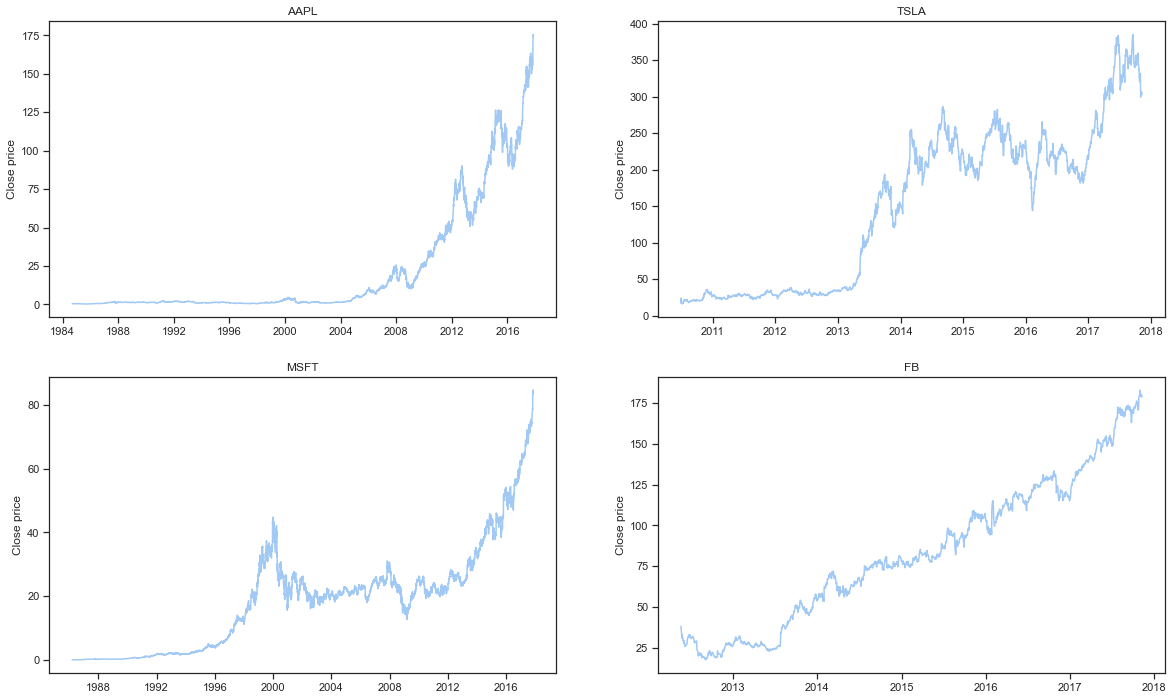

In [5]:
plt.figure(figsize=(20, 12))
for index, key in enumerate(companies):
  plt.subplot(2, 2, index + 1)
  plt.plot(stocks[key]["Date"], stocks[key]["Close"])
  plt.title(key)
  plt.ylabel('Close price')

In [6]:
def SplitData(data, time_slice):
    index_mark = int(len(data) * 0.8)
    data = data['Close'].values
    close_train=data[0:index_mark]
    
    X_train = []
    Y_train = []
    for i in range(index_mark - time_slice):
        X_train.append(close_train[i:i+time_slice])
        Y_train.append(close_train[i+time_slice])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape((-1, 5, 1)) 
    Y_train = Y_train.reshape(-1, 1)

    close_test=data[index_mark:]
    X_test = []
    Y_test = []
    for i in range(len(close_test) - time_slice):
        X_test.append(close_test[i:i+time_slice])
        Y_test.append(close_test[i+time_slice])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = X_test.reshape((-1, 5, 1))
    Y_test = Y_test.reshape(-1, 1)

    return X_train, Y_train, X_test, Y_test

## Create model

In [7]:
def Model():
  model = tf.keras.models.Sequential(
      [
          tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
          tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(1, activation = tf.nn.leaky_relu)
      ]
  )
  return model

In [8]:
model = Model()

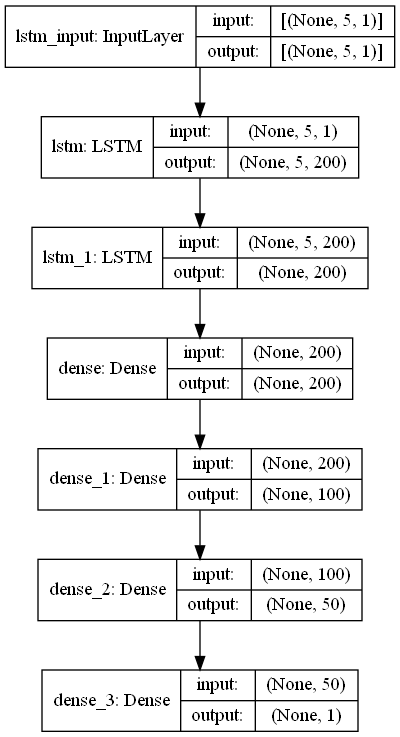

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 547,801
Trainable params: 547,801
Non-trainable params: 0
__________________________________________________

## Custom Learning Rate

In [11]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

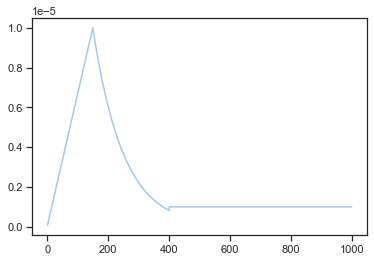

In [12]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)
plt.show()

In [13]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Train model

### Apple model

In [14]:
AAPL_X_train, AAPL_Y_train, AAPL_X_test, AAPL_Y_test = SplitData(stocks['AAPL'], 5)

In [15]:
AAPL_Model = Model()

In [16]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [17]:
# Measuring the time taken by the model to train
start_time=time.time()
AAPL_hist = AAPL_Model.fit(AAPL_X_train, AAPL_Y_train, epochs = 400, validation_data = (AAPL_X_test, AAPL_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: {:.2f} Minutes ##".format((end_time-start_time)/60))

============] - 2s 12ms/step - loss: 0.0591 - root_mean_squared_error: 0.2427 - val_loss: 79.1942 - val_root_mean_squared_error: 8.8991
Epoch 289/400
209/209 [==============================] - 2s 12ms/step - loss: 0.0587 - root_mean_squared_error: 0.2420 - val_loss: 96.5501 - val_root_mean_squared_error: 9.8260
Epoch 290/400
209/209 [==============================] - 2s 12ms/step - loss: 0.0602 - root_mean_squared_error: 0.2451 - val_loss: 90.6723 - val_root_mean_squared_error: 9.5222
Epoch 291/400
209/209 [==============================] - 2s 12ms/step - loss: 0.0601 - root_mean_squared_error: 0.2450 - val_loss: 89.2278 - val_root_mean_squared_error: 9.4460
Epoch 292/400
209/209 [==============================] - 2s 12ms/step - loss: 0.0552 - root_mean_squared_error: 0.2342 - val_loss: 71.9162 - val_root_mean_squared_error: 8.4803
Epoch 293/400
209/209 [==============================] - 2s 12ms/step - loss: 0.0535 - root_mean_squared_error: 0.2308 - val_loss: 61.8440 - val_root_mean_s

In [18]:
AAPL_Model.save('./model/AAPL/AAPL_LSTM.h5')

In [19]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

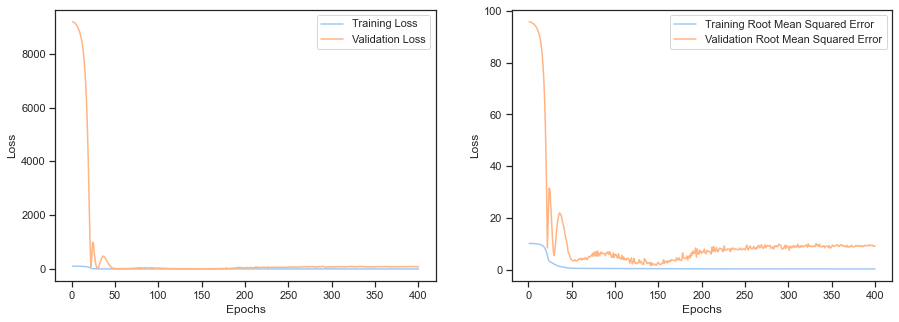

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [21]:
### Predicting the closing stock price
AAPL_prediction = AAPL_Model.predict(AAPL_X_test)

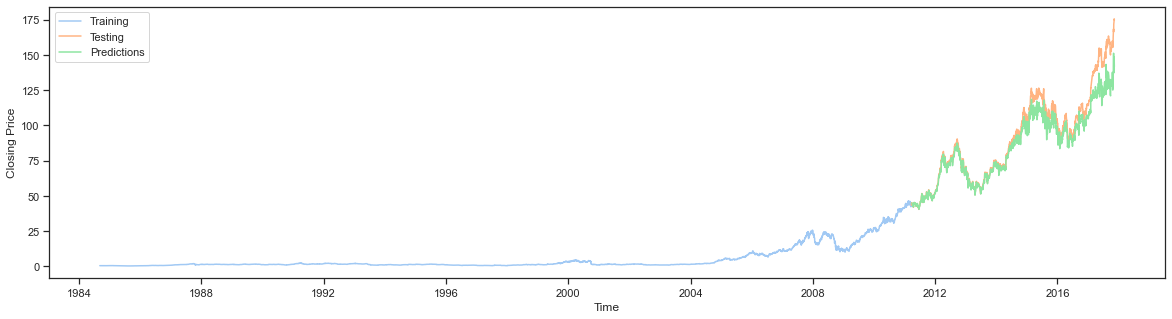

In [22]:
plt.figure(figsize=(20, 5))
i_AAPL_mark = int(len(stocks['AAPL']) * 0.8)
plt.plot(stocks['AAPL']['Date'][:i_AAPL_mark], 
        stocks['AAPL']['Close'][:i_AAPL_mark], label = 'Training')

plt.plot(stocks['AAPL']['Date'][i_AAPL_mark:], 
        stocks['AAPL']['Close'][i_AAPL_mark:], label = 'Testing')

plt.plot(stocks['AAPL']['Date'][i_AAPL_mark+5:], 
        AAPL_prediction, label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

plt.show()

In [23]:
from sklearn.metrics import r2_score
r2 = r2_score(AAPL_Y_test, AAPL_prediction)
rmse = math.sqrt(mean_squared_error(AAPL_Y_test, AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Y_test)/np.abs(AAPL_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 9.067535258888162
MAPE: 0.05052402410939159
R2 score: 0.915835809710388


In [24]:
avaluate = pd.DataFrame({'AAPL': [rmse,mape,r2]},index=["RMSE", "MAPE", "R2 score"])
avaluate

,AAPL
RMSE,9.067535
MAPE,0.050524
R2 score,0.915836


### Tesla model

In [25]:
TSLA_X_train, TSLA_Y_train, TSLA_X_test, TSLA_Y_test = SplitData(stocks['TSLA'], 5)

In [26]:
TSLA_Model = Model()

In [27]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [28]:
# Measuring the time taken by the model to train
start_time=time.time()
TSLA_hist = TSLA_Model.fit(TSLA_X_train, TSLA_Y_train, epochs = 400, validation_data = (TSLA_X_test, TSLA_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: {:.2f} Minutes ##".format((end_time-start_time)/60))

ed_error: 4.2343 - val_loss: 61.6892 - val_root_mean_squared_error: 7.8542
Epoch 288/400
47/47 [==============================] - 1s 12ms/step - loss: 19.9504 - root_mean_squared_error: 4.4505 - val_loss: 57.1083 - val_root_mean_squared_error: 7.5570
Epoch 289/400
47/47 [==============================] - 1s 12ms/step - loss: 18.9970 - root_mean_squared_error: 4.3563 - val_loss: 56.8324 - val_root_mean_squared_error: 7.5387
Epoch 290/400
47/47 [==============================] - 1s 12ms/step - loss: 15.9540 - root_mean_squared_error: 3.9853 - val_loss: 53.2457 - val_root_mean_squared_error: 7.2970
Epoch 291/400
47/47 [==============================] - 1s 13ms/step - loss: 16.6388 - root_mean_squared_error: 4.0667 - val_loss: 58.8321 - val_root_mean_squared_error: 7.6702
Epoch 292/400
47/47 [==============================] - 1s 13ms/step - loss: 18.7550 - root_mean_squared_error: 4.3270 - val_loss: 54.9172 - val_root_mean_squared_error: 7.4106
Epoch 293/400
47/47 [========================

In [29]:
TSLA_Model.save('./model/TSLA/TSLA_LSTM.h5')

In [30]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

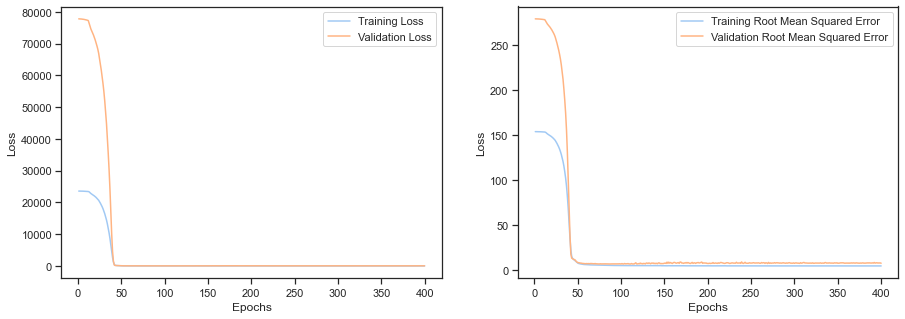

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [32]:
### Predicting the closing stock price
TSLA_prediction = TSLA_Model.predict(TSLA_X_test)

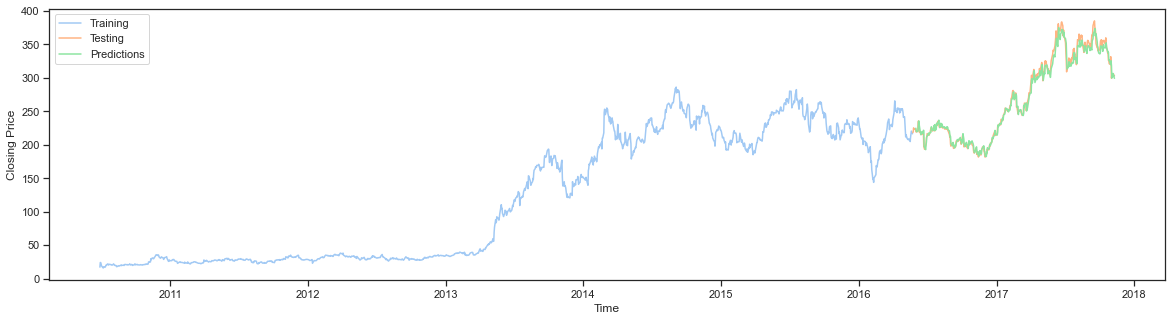

In [33]:
plt.figure(figsize=(20, 5))
i_TSLA_mark = int(len(stocks['TSLA']) * 0.8)
plt.plot(stocks['TSLA']['Date'][:i_TSLA_mark], 
        stocks['TSLA']['Close'][:i_TSLA_mark], label = 'Training')

plt.plot(stocks['TSLA']['Date'][i_TSLA_mark:], 
        stocks['TSLA']['Close'][i_TSLA_mark:], label = 'Testing')

plt.plot(stocks['TSLA']['Date'][i_TSLA_mark+5:], 
        TSLA_prediction, label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

plt.show()

In [34]:
r2 = r2_score(TSLA_Y_test, TSLA_prediction)
rmse = math.sqrt(mean_squared_error(TSLA_Y_test, TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Y_test)/np.abs(TSLA_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 7.358701921726407
MAPE: 0.01903762708185625
R2 score: 0.986097544060154


In [35]:
avaluate.insert(0, 'TSLA', [rmse,mape,r2])

### Microsoft model

In [36]:
MSFT_X_train, MSFT_Y_train, MSFT_X_test, MSFT_Y_test = SplitData(stocks['MSFT'], 5)

In [37]:
MSFT_Model = Model()

In [38]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [39]:
# Measuring the time taken by the model to train
start_time=time.time()
MSFT_hist = MSFT_Model.fit(MSFT_X_train, MSFT_Y_train, epochs = 400, validation_data = (MSFT_X_test, MSFT_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: {:.2f} Minutes ##".format((end_time-start_time)/60))

ed_error: 0.4052 - val_loss: 2.7782 - val_root_mean_squared_error: 1.6668
Epoch 288/400
200/200 [==============================] - 3s 13ms/step - loss: 0.1618 - root_mean_squared_error: 0.4020 - val_loss: 2.8671 - val_root_mean_squared_error: 1.6933
Epoch 289/400
200/200 [==============================] - 3s 13ms/step - loss: 0.1545 - root_mean_squared_error: 0.3926 - val_loss: 2.6214 - val_root_mean_squared_error: 1.6191
Epoch 290/400
200/200 [==============================] - 3s 13ms/step - loss: 0.1573 - root_mean_squared_error: 0.3963 - val_loss: 2.3961 - val_root_mean_squared_error: 1.5479
Epoch 291/400
200/200 [==============================] - 3s 13ms/step - loss: 0.1700 - root_mean_squared_error: 0.4118 - val_loss: 2.4711 - val_root_mean_squared_error: 1.5720
Epoch 292/400
200/200 [==============================] - 3s 14ms/step - loss: 0.1578 - root_mean_squared_error: 0.3964 - val_loss: 2.1245 - val_root_mean_squared_error: 1.4576
Epoch 293/400
200/200 [=======================

In [40]:
MSFT_Model.save('./model/MSFT/MSFT_LSTM.h5')

In [41]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

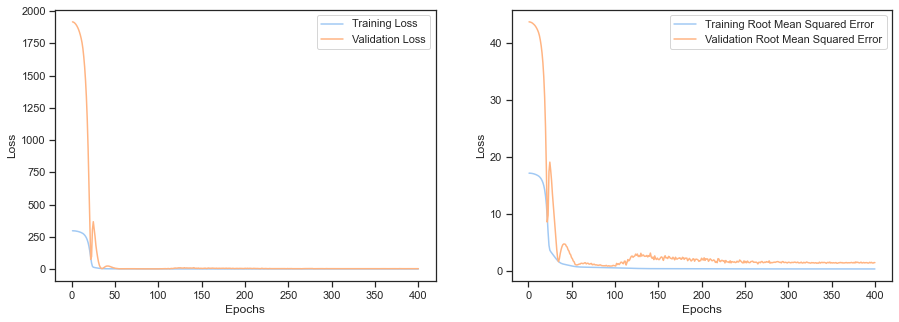

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [43]:
### Predicting the closing stock price
MSFT_prediction = MSFT_Model.predict(MSFT_X_test)

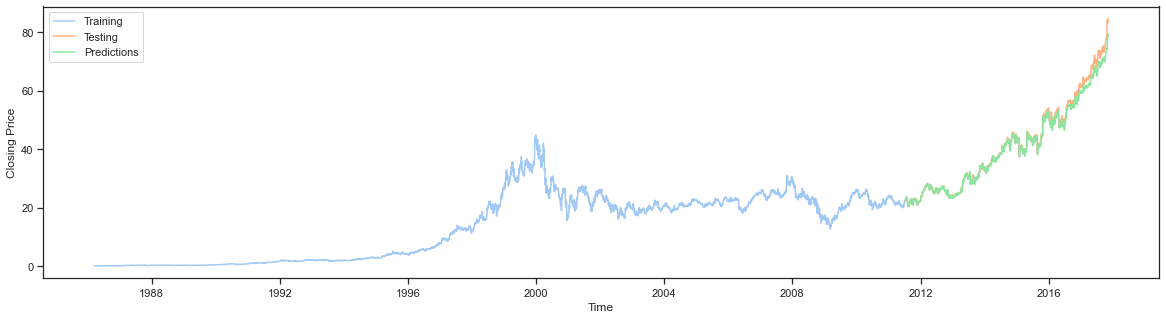

In [44]:
plt.figure(figsize=(20, 5))
i_MSFT_mark = int(len(stocks['MSFT']) * 0.8)
plt.plot(stocks['MSFT']['Date'][:i_MSFT_mark], 
        stocks['MSFT']['Close'][:i_MSFT_mark], label = 'Training')

plt.plot(stocks['MSFT']['Date'][i_MSFT_mark:], 
        stocks['MSFT']['Close'][i_MSFT_mark:], label = 'Testing')

plt.plot(stocks['MSFT']['Date'][i_MSFT_mark+5:], 
        MSFT_prediction, label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [45]:
r2 = r2_score(MSFT_Y_test, MSFT_prediction)
rmse = math.sqrt(mean_squared_error(MSFT_Y_test, MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Y_test)/np.abs(MSFT_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 1.5046498279844533
MAPE: 0.018638179428113744
R2 score: 0.9905184949949951


In [46]:
avaluate.insert(0, 'MSFT', [rmse,mape,r2])

### Facebook model

In [47]:
FB_X_train, FB_Y_train, FB_X_test, FB_Y_test = SplitData(stocks['FB'], 5)

In [48]:
FB_Model = Model()

In [49]:
FB_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [50]:
# Measuring the time taken by the model to train
start_time=time.time()
FB_hist = FB_Model.fit(FB_X_train, FB_Y_train, epochs = 400, validation_data = (FB_X_test, FB_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: {:.2f} Minutes ##".format((end_time-start_time)/60))

====] - 1s 16ms/step - loss: 2.2311 - root_mean_squared_error: 1.4917 - val_loss: 3.2678 - val_root_mean_squared_error: 1.8077
Epoch 287/400
35/35 [==============================] - 0s 14ms/step - loss: 2.6496 - root_mean_squared_error: 1.6191 - val_loss: 3.1770 - val_root_mean_squared_error: 1.7824
Epoch 288/400
35/35 [==============================] - 0s 14ms/step - loss: 2.4484 - root_mean_squared_error: 1.5616 - val_loss: 3.2290 - val_root_mean_squared_error: 1.7969
Epoch 289/400
35/35 [==============================] - 1s 15ms/step - loss: 2.3172 - root_mean_squared_error: 1.5169 - val_loss: 3.2571 - val_root_mean_squared_error: 1.8047
Epoch 290/400
35/35 [==============================] - 0s 14ms/step - loss: 2.3219 - root_mean_squared_error: 1.5216 - val_loss: 3.3640 - val_root_mean_squared_error: 1.8341
Epoch 291/400
35/35 [==============================] - 0s 13ms/step - loss: 2.2799 - root_mean_squared_error: 1.5083 - val_loss: 3.1782 - val_root_mean_squared_error: 1.7827
Epo

In [51]:
FB_Model.save('./model/FB/FB_LSTM.h5')

In [52]:
history_dict = FB_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

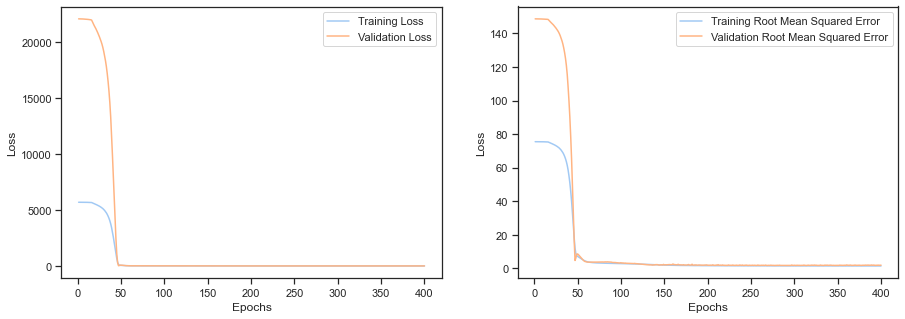

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [54]:
### Predicting the closing stock price
FB_prediction = FB_Model.predict(FB_X_test)

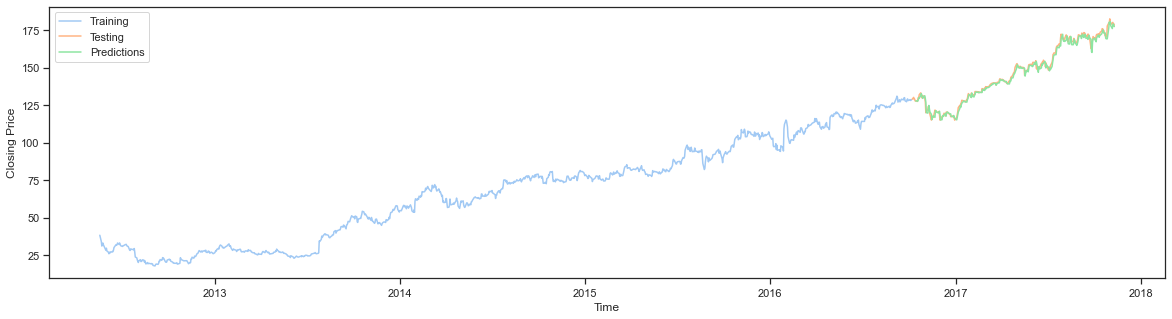

In [55]:
plt.figure(figsize=(20, 5))
i_FB_mark = int(len(stocks['FB']) * 0.8)
plt.plot(stocks['FB']['Date'][:i_FB_mark], 
        stocks['FB']['Close'][:i_FB_mark], label = 'Training')

plt.plot(stocks['FB']['Date'][i_FB_mark:], 
        stocks['FB']['Close'][i_FB_mark:], label = 'Testing')

plt.plot(stocks['FB']['Date'][i_FB_mark+5:], 
        FB_prediction, label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

plt.show()

In [56]:
r2 = r2_score(FB_Y_test, FB_prediction)
rmse = math.sqrt(mean_squared_error(FB_Y_test, FB_prediction))
mape = np.mean(np.abs(FB_prediction - FB_Y_test)/np.abs(FB_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 1.9669074227907701
MAPE: 0.00969972763104044
R2 score: 0.9896614889522949


In [57]:
avaluate.insert(0, 'FB', [rmse,mape,r2])
avaluate

,FB,MSFT,TSLA,AAPL
RMSE,1.966907,1.504650,7.358702,9.067535
MAPE,0.009700,0.018638,0.019038,0.050524
R2 score,0.989661,0.990518,0.986098,0.915836


In [58]:
avaluate.to_csv("LSTM_avaluate.csv")